In [1]:
import json
import pathlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/simulation_json/config_Zendure2400_noBattery.json",
    "out/simulation_json/config_Zendure2400_2880kwh.json",
    "out/simulation_json/config_Zendure2400_5760kwh.json",
    "out/simulation_json/config_Zendure2400_8640kwh.json",
    "out/simulation_json/config_Zendure2400_11520kwh.json",
    "out/simulation_json/config_Zendure2400_14400kwh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])

SEASON_ORDER = ["spring", "summer", "autumn", "winter"]
EXPORT_FIGURES = True
SEASON_FIG_DIR = pathlib.Path("out/season_images")
SEASON_FIG_DIR.mkdir(parents=True, exist_ok=True)

FIG_EXPORT_COUNTER = 0

def export_current_figure(out_dir):
    global FIG_EXPORT_COUNTER
    if not EXPORT_FIGURES:
        return

    title = plt.gca().get_title() or "figure"
    slug = re.sub(r"[^a-z0-9]+", "_", title.lower()).strip("_")
    FIG_EXPORT_COUNTER += 1

    out_path = out_dir / f"{FIG_EXPORT_COUNTER:02d}_{slug}.png"
    plt.savefig(out_path, dpi=200)
    print(f"Saved figure: {out_path}")


Extract seasonal total_gain_chf

In [2]:
rows = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    seasons = data.get("seasons")
    if seasons is None:
        print(f"⚠️ No seasons section in {scenario}, skipping")
        continue

    for season, values in seasons.items():
        flows = values.get("energy_flows", {})
        with_batt = flows.get("with_battery", {})
        without_batt = flows.get("without_battery", {})
        saturation = values.get("battery_saturation", {})
        energy_undersize = values.get("battery_energy_undersize_days", {})
        evening_undersize = values.get("battery_evening_undersize_days", {})
        pu = values.get("power_usage", {})
        charging_at_max = pu.get("charging", {}).get("at_max", {}).get("samples_percent", 0.0)
        discharging_at_max = pu.get("discharging", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_charge_at_max = pu.get("idle", {}).get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_discharge_at_max = pu.get("idle", {}).get("could_discharge", {}).get("at_max", {}).get("samples_percent", 0.0)
        
        idle = pu.get("idle", {})
        could_charge_at_max = (idle.get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0))
        no_opportunity = idle.get("no_opportunity", {}).get("samples_percent", 0.0)

        charging_not_at_max = pu.get("charging", {}).get("not_at_max", {}).get("samples_percent", 0.0)
        discharging_not_at_max = pu.get("discharging", {}).get("not_at_max", {}).get("samples_percent", 0.0)

        idle_could_charge_not_at_max = (
            idle.get("could_charge", {})
                .get("not_at_max", {})
                .get("samples_percent", 0.0)
        )

        idle_could_discharge_not_at_max = (
            idle.get("could_discharge", {})
                .get("not_at_max", {})
                .get("samples_percent", 0.0)
        )

        idle_no_opportunity = idle.get("no_opportunity", {}).get("samples_percent", 0.0)

        rows.append({
            "season": season.lower(),
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "total_gain_chf": values.get("total_gain_chf", 0.0),

            "grid_consumed_with_kwh": with_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_with_kwh": with_batt.get("grid_injected_kwh", 0.0),

            "grid_consumed_without_kwh": without_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_without_kwh": without_batt.get("grid_injected_kwh", 0.0),
            
            "battery_charged_kwh": with_batt.get("battery_charged_kwh", 0.0),
            "battery_discharged_kwh": with_batt.get("battery_discharged_kwh", 0.0),   

            "avg_full_pct": 100.0 if battery_size_wh == 0 else saturation.get("average_full_share_percent", 0.0),
            "avg_empty_pct": saturation.get("average_empty_share_percent", 0.0),

            "energy_undersize_pct": energy_undersize.get("percent", 0.0),
            "evening_undersize_pct": evening_undersize.get("percent", 0.0),

            "power_at_max_pct": charging_at_max + discharging_at_max + idle_could_charge_at_max + idle_could_discharge_at_max,

            "charging_at_max_pct": charging_at_max,
            "discharging_at_max_pct": discharging_at_max,
            "idle_could_charge_at_max_pct": idle_could_charge_at_max,
            "idle_could_discharge_at_max_pct": idle_could_discharge_at_max,
            "active_power_at_max_pct": charging_at_max + discharging_at_max,
            "idle_power_limited_pct" : idle_could_discharge_at_max + idle_could_charge_at_max,
            "idle_could_charge_at_max_pct": could_charge_at_max,
            "charging_not_at_max_pct": charging_not_at_max,
            "discharging_not_at_max_pct": discharging_not_at_max,
            "idle_could_charge_not_at_max_pct": idle_could_charge_not_at_max,
            "idle_could_discharge_not_at_max_pct": idle_could_discharge_not_at_max,
            "idle_no_opportunity_pct": idle_no_opportunity,
        })

df_energy = pd.DataFrame(rows)

df_energy["season"] = pd.Categorical(
    df_energy["season"],
    categories=SEASON_ORDER,
    ordered=True
)

df_energy = df_energy.sort_values("battery_size_wh")

scenario_order = (
    df_energy[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)

Plot – Seasonal Total Gain (CHF)

Saved figure: out/season_images/01_net_financial_gain_vs_battery_size_per_season.png


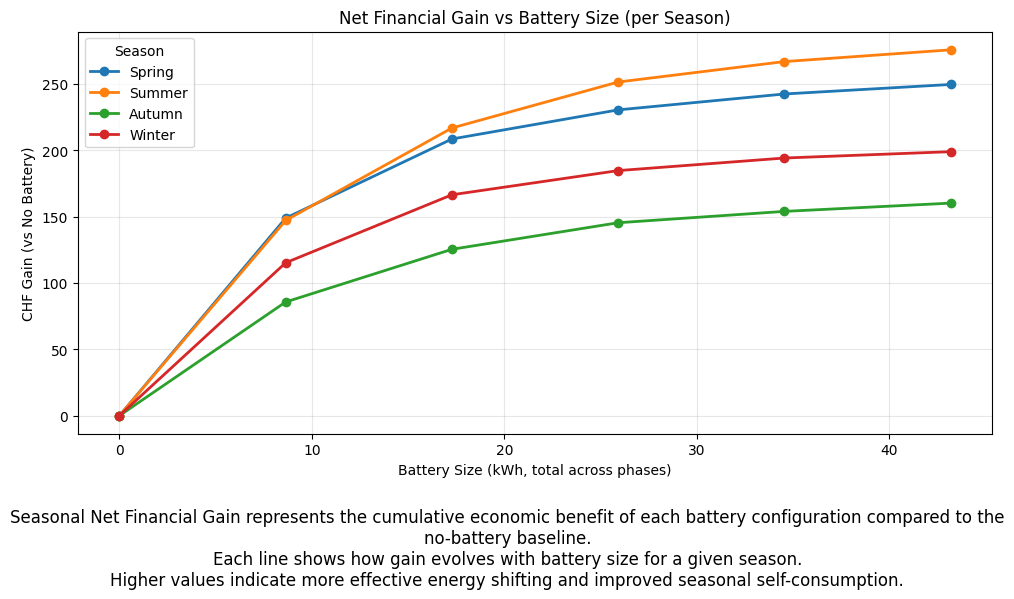

In [3]:

# =========================
# Net Financial Gain vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["total_gain_chf"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Net Financial Gain vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("CHF Gain (vs No Battery)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Net Financial Gain represents the cumulative economic benefit "
    "of each battery configuration compared to the no-battery baseline.\n"
    "Each line shows how gain evolves with battery size for a given season.\n"
    "Higher values indicate more effective energy shifting and improved seasonal self-consumption.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph 1 – Seasonal Grid Consumed (with battery)

Saved figure: out/season_images/02_grid_import_reduction_vs_battery_size_per_season.png


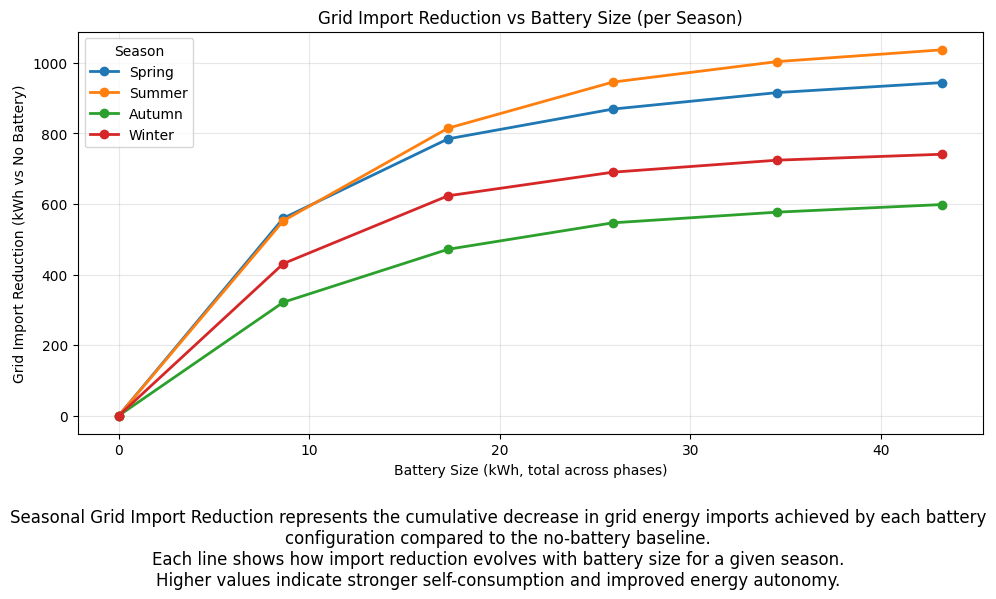

In [4]:

# =========================
# Grid Import Reduction vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh").copy()
dfp["grid_import_reduction_kwh"] = dfp["grid_consumed_without_kwh"] - dfp["grid_consumed_with_kwh"]

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["grid_import_reduction_kwh"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Grid Import Reduction vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Grid Import Reduction (kWh vs No Battery)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Grid Import Reduction represents the cumulative decrease in grid energy "
    "imports achieved by each battery configuration compared to the no-battery baseline.\n"
    "Each line shows how import reduction evolves with battery size for a given season.\n"
    "Higher values indicate stronger self-consumption and improved energy autonomy.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph 2 – Seasonal Grid Injected (with battery)

Saved figure: out/season_images/03_grid_export_reduction_vs_battery_size_per_season.png


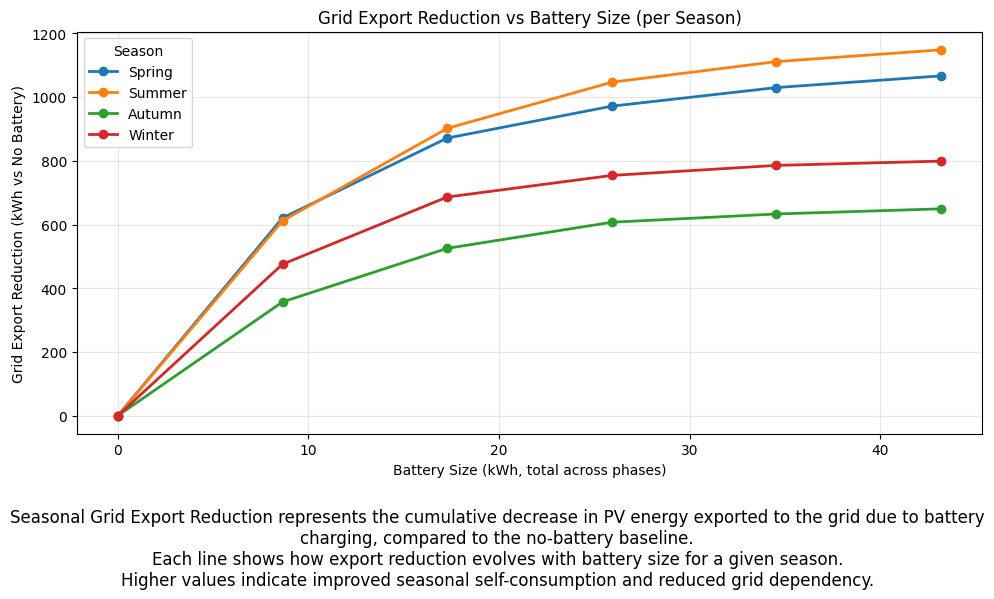

In [5]:

# =========================
# Grid Export Reduction vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh").copy()
dfp["grid_export_reduction_kwh"] = dfp["grid_injected_without_kwh"] - dfp["grid_injected_with_kwh"]

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["grid_export_reduction_kwh"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Grid Export Reduction vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Grid Export Reduction (kWh vs No Battery)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Grid Export Reduction represents the cumulative decrease in PV energy exported to the grid due to battery charging, compared to the no-battery baseline.\nEach line shows how export reduction evolves with battery size for a given season.\nHigher values indicate improved seasonal self-consumption and reduced grid dependency.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph – Seasonal Battery Charged / Dicharged Energy

Saved figure: out/season_images/04_battery_energy_flow_vs_battery_size_per_season.png


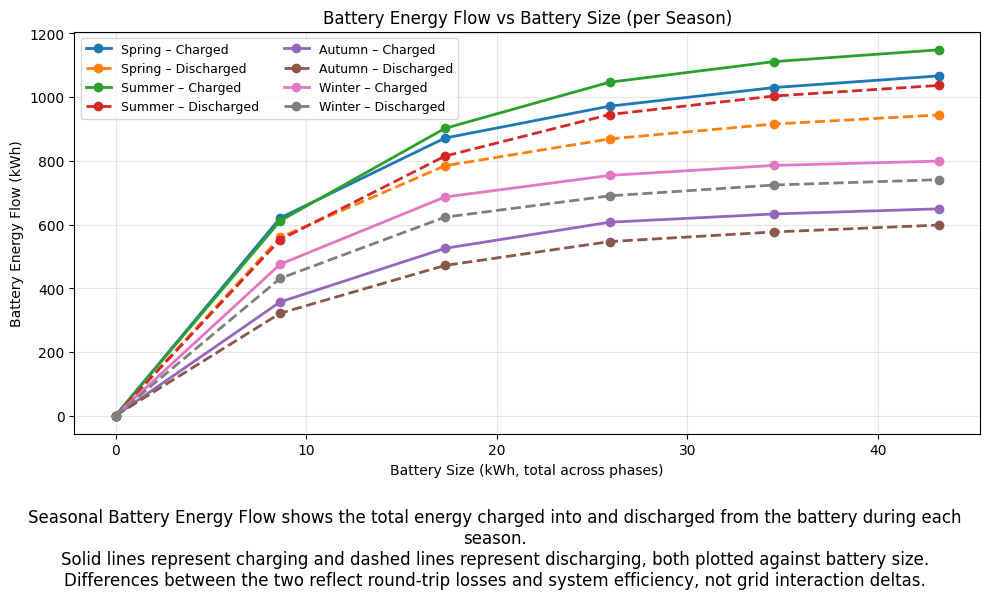

In [6]:

# =========================
# Battery Energy Flow vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,
        sub["battery_charged_kwh"],
        marker="o",
        linestyle="-",
        linewidth=2,
        label=f"{season.capitalize()} – Charged",
    )
    ax.plot(
        sub["battery_size_wh"] / 1000,
        sub["battery_discharged_kwh"],
        marker="o",
        linestyle="--",
        linewidth=2,
        label=f"{season.capitalize()} – Discharged",
    )

ax.set_title("Battery Energy Flow vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Battery Energy Flow (kWh)")
ax.legend(ncol=2, fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Energy Flow shows the total energy charged into and discharged from the battery during each season.\n"
    "Solid lines represent charging and dashed lines represent discharging, both plotted against battery size.\n"
    "Differences between the two reflect round-trip losses and system efficiency, not grid interaction deltas.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Seasonal Battery Throughput

Saved figure: out/season_images/05_battery_energy_throughput_vs_battery_size_per_season.png


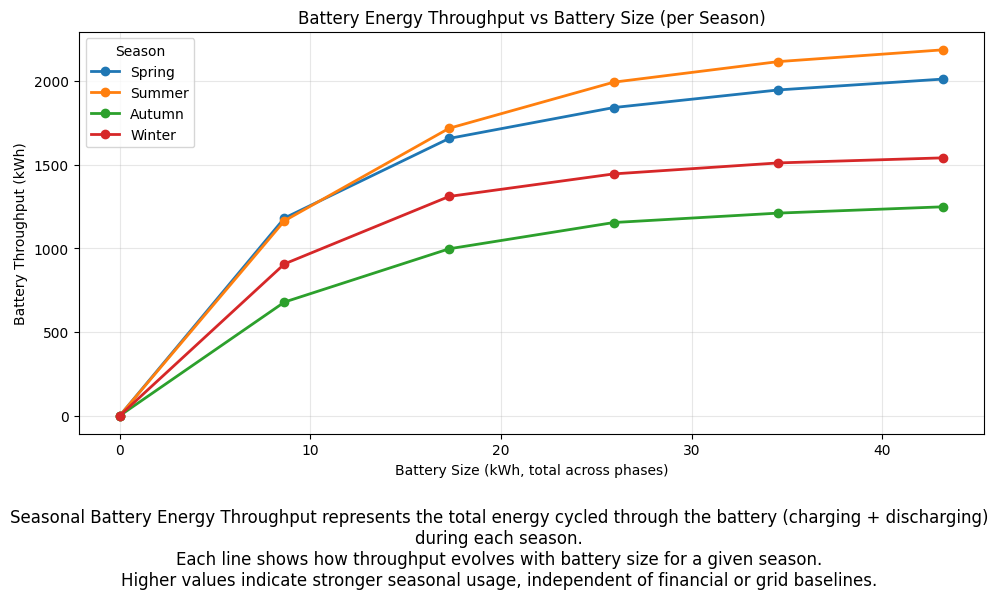

In [7]:

# =========================
# Battery Energy Throughput vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh").copy()
dfp["battery_throughput_kwh"] = dfp["battery_charged_kwh"] + dfp["battery_discharged_kwh"]

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["battery_throughput_kwh"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Battery Energy Throughput vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Battery Throughput (kWh)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Energy Throughput represents the total energy cycled through the battery (charging + discharging) during each season.\nEach line shows how throughput evolves with battery size for a given season.\nHigher values indicate stronger seasonal usage, independent of financial or grid baselines.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Seasonal Battery FULL share

Saved figure: out/season_images/06_battery_full_saturation_vs_battery_size_per_season.png


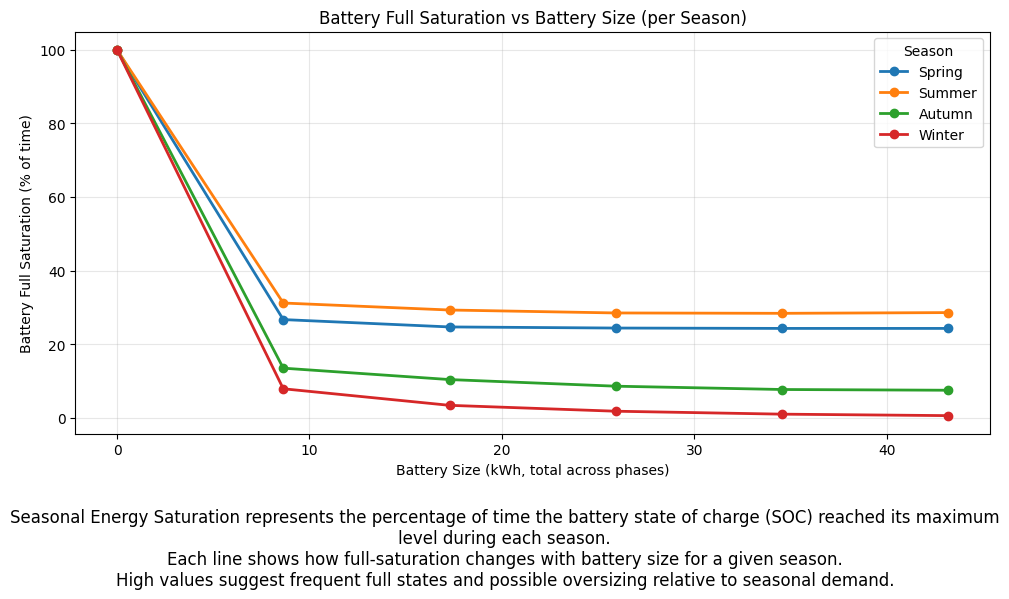

In [8]:

# =========================
# Battery Full Saturation vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["avg_full_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Battery Full Saturation vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Battery Full Saturation (% of time)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Energy Saturation represents the percentage of time the battery state of charge (SOC) reached its maximum level during each season.\nEach line shows how full-saturation changes with battery size for a given season.\nHigh values suggest frequent full states and possible oversizing relative to seasonal demand.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Seasonal Battery EMPTY share

Saved figure: out/season_images/07_battery_empty_limitation_vs_battery_size_per_season.png


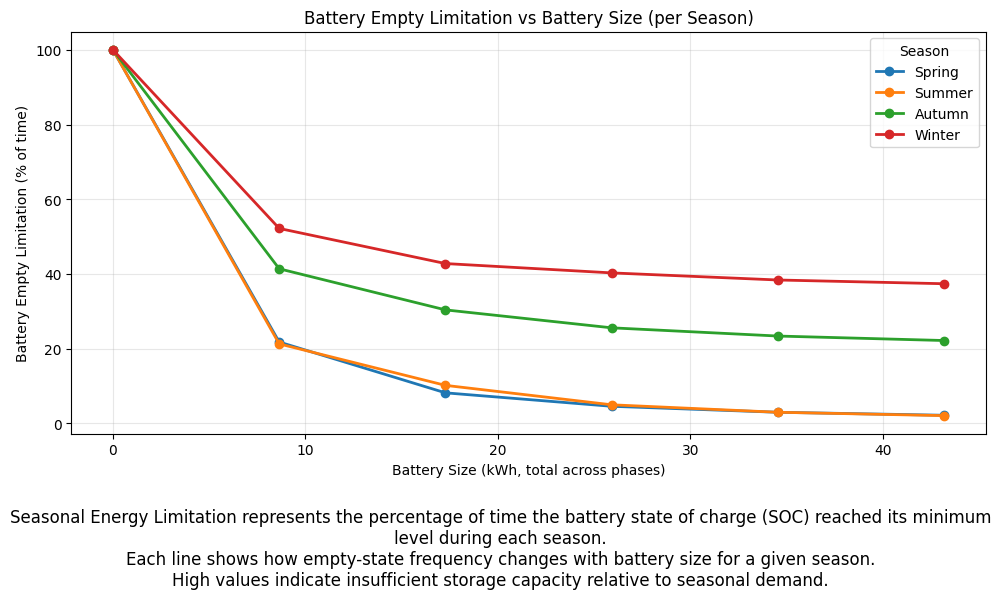

In [9]:

# =========================
# Battery Empty Limitation vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["avg_empty_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Battery Empty Limitation vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Battery Empty Limitation (% of time)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Energy Limitation represents the percentage of time the battery state of charge (SOC) reached its minimum level during each season.\nEach line shows how empty-state frequency changes with battery size for a given season.\nHigh values indicate insufficient storage capacity relative to seasonal demand.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph – Seasonal Energy Undersize Days

Saved figure: out/season_images/08_structural_energy_undersizing_vs_battery_size_per_season.png


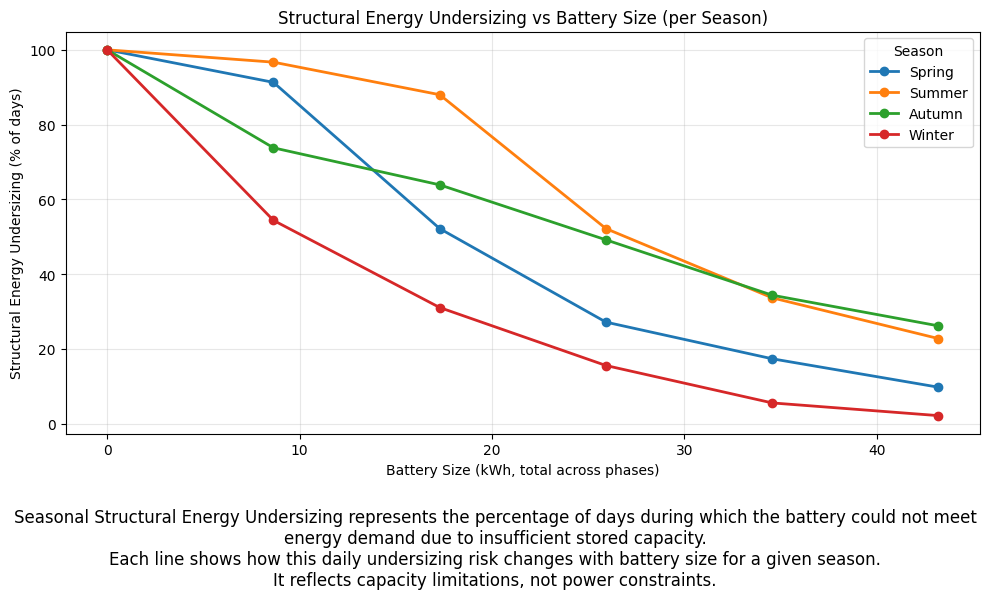

In [10]:

# =========================
# Structural Energy Undersizing vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["energy_undersize_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Structural Energy Undersizing vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Structural Energy Undersizing (% of days)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Structural Energy Undersizing represents the percentage of days during which the battery could not meet energy demand due to insufficient stored capacity.\nEach line shows how this daily undersizing risk changes with battery size for a given season.\nIt reflects capacity limitations, not power constraints.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph – Seasonal Evening Undersize Days

Saved figure: out/season_images/09_evening_energy_undersizing_vs_battery_size_per_season.png


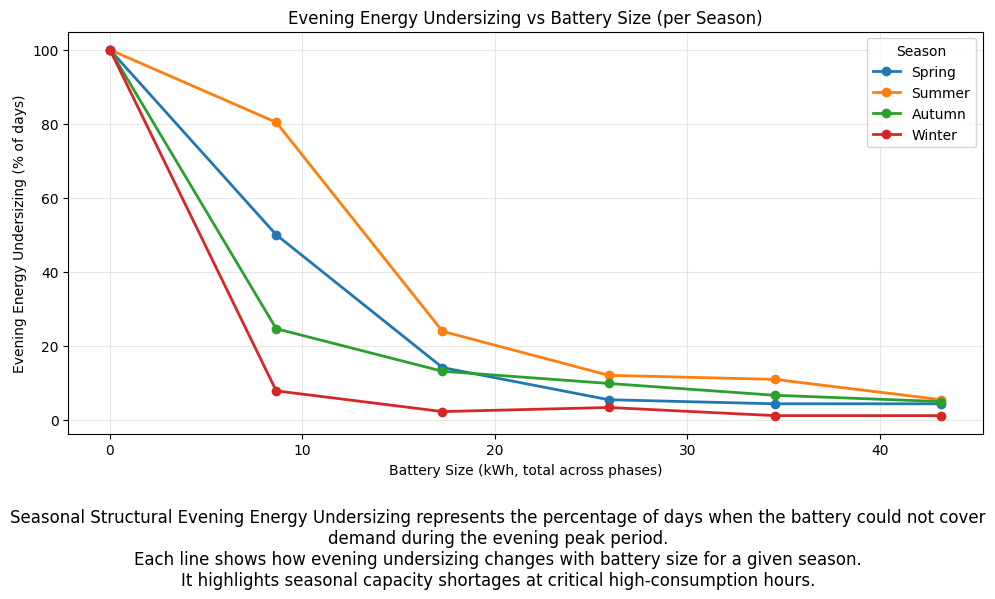

In [11]:

# =========================
# Evening Energy Undersizing vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["evening_undersize_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Evening Energy Undersizing vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Evening Energy Undersizing (% of days)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Structural Evening Energy Undersizing represents the percentage of days when the battery could not cover demand during the evening peak period.\nEach line shows how evening undersizing changes with battery size for a given season.\nIt highlights seasonal capacity shortages at critical high-consumption hours.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Plot – Seasonal Power Saturation

Saved figure: out/season_images/10_power_saturation_at_max_limit_vs_battery_size_per_season.png


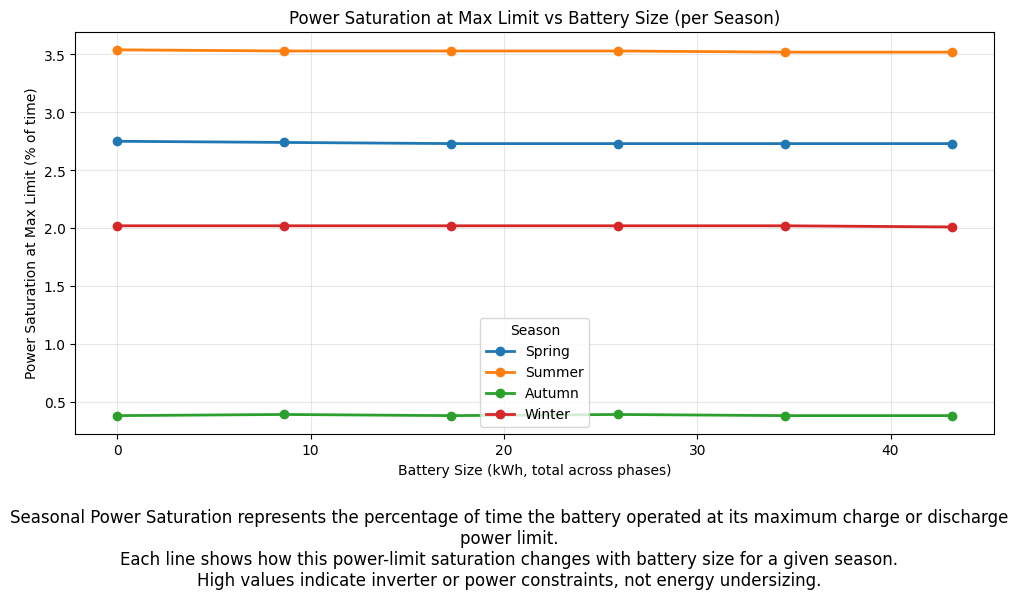

In [12]:

# =========================
# Power Saturation at Max Limit vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["power_at_max_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Power Saturation at Max Limit vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Power Saturation at Max Limit (% of time)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Power Saturation represents the percentage of time the battery operated at its maximum charge or discharge power limit.\nEach line shows how this power-limit saturation changes with battery size for a given season.\nHigh values indicate inverter or power constraints, not energy undersizing.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Saved figure: out/season_images/11_active_power_saturation_vs_battery_size_per_season.png


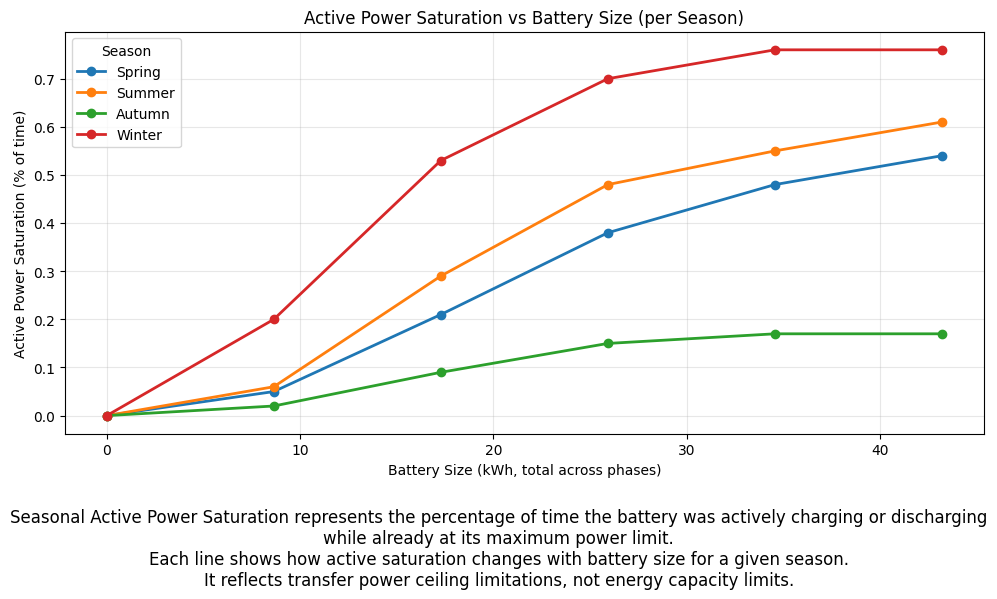

In [13]:

# =========================
# Active Power Saturation vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["active_power_at_max_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Active Power Saturation vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Active Power Saturation (% of time)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Active Power Saturation represents the percentage of time the battery was actively charging or discharging while already at its maximum power limit.\nEach line shows how active saturation changes with battery size for a given season.\nIt reflects transfer power ceiling limitations, not energy capacity limits.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Saved figure: out/season_images/12_idle_power_limited_time_vs_battery_size_per_season.png


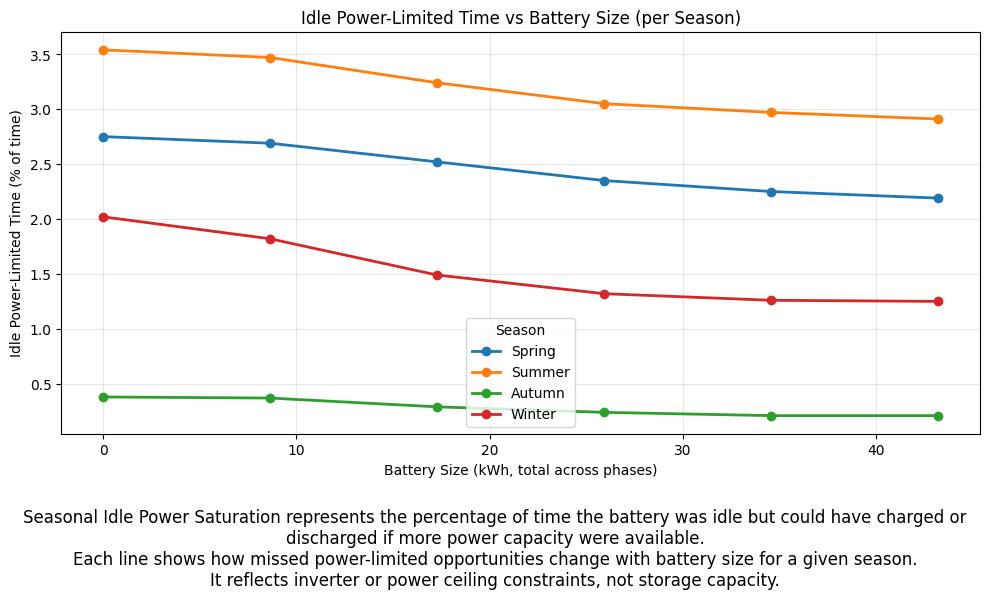

In [14]:

# =========================
# Idle Power-Limited Time vs Battery Size (per Season)
# =========================

# Ensure correct order by battery size
dfp = df_energy.sort_values("battery_size_wh")

fig, ax = plt.subplots(figsize=(10, 6))

for season in SEASON_ORDER:
    sub = dfp[dfp["season"] == season].sort_values("battery_size_wh")
    if sub.empty:
        continue
    ax.plot(
        sub["battery_size_wh"] / 1000,  # convert Wh -> kWh
        sub["idle_power_limited_pct"],
        marker="o",
        linewidth=2,
        label=season.capitalize(),
    )

ax.set_title("Idle Power-Limited Time vs Battery Size (per Season)")
ax.set_xlabel("Battery Size (kWh, total across phases)")
ax.set_ylabel("Idle Power-Limited Time (% of time)")
ax.legend(title="Season")
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.17, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Idle Power Saturation represents the percentage of time the battery was idle but could have charged or discharged if more power capacity were available.\nEach line shows how missed power-limited opportunities change with battery size for a given season.\nIt reflects inverter or power ceiling constraints, not storage capacity.",
    ha="center",
    fontsize=12,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Saved figure: out/season_images/13_seasonal_power_state_distribution_active_idle_modes.png


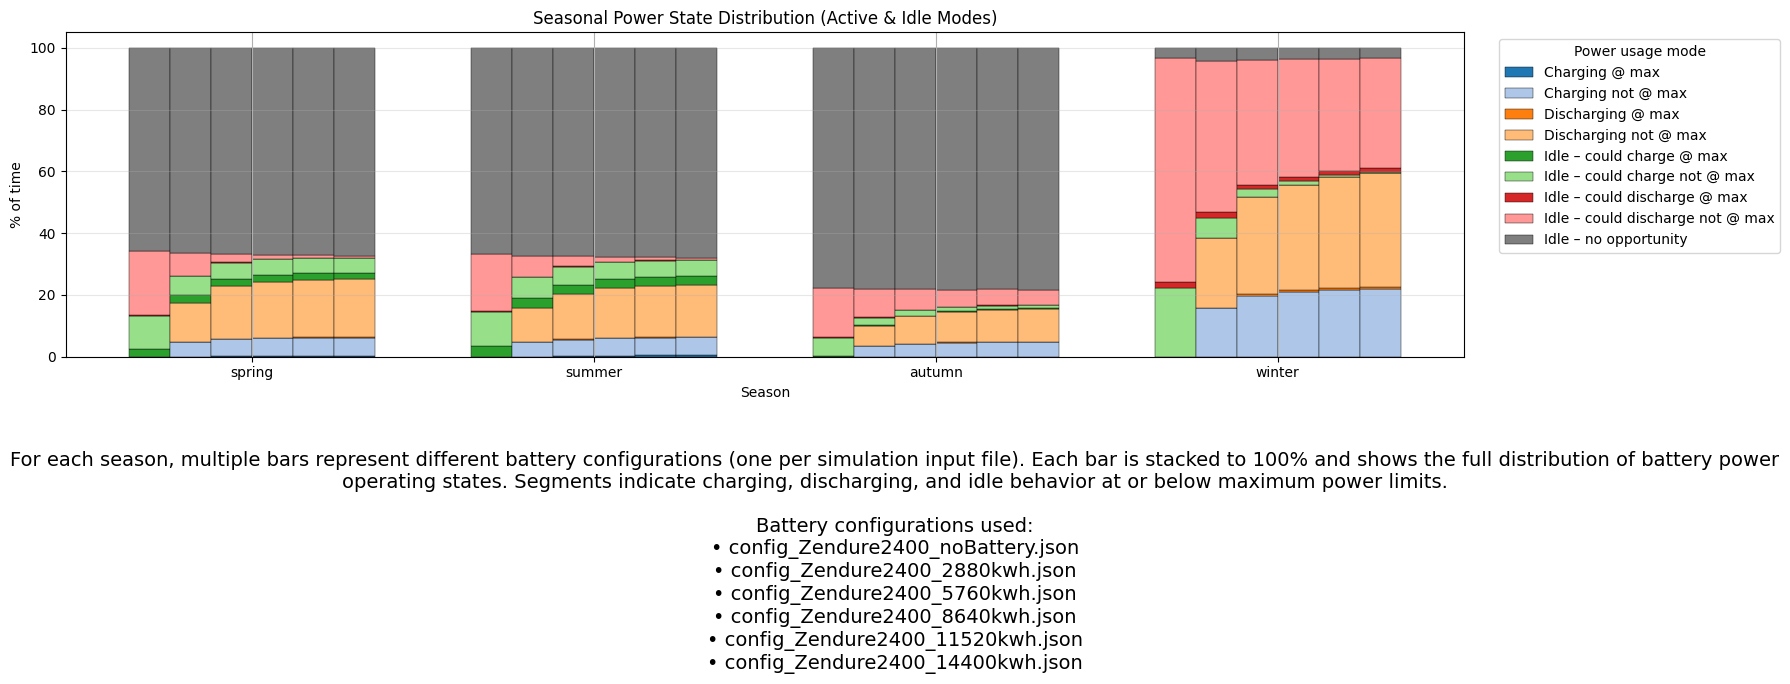

In [15]:
STACK_COMPONENTS = [
    # Charging
    ("charging_at_max_pct", "Charging @ max", "#1f77b4"),
    ("charging_not_at_max_pct", "Charging not @ max", "#aec7e8"),

    # Discharging
    ("discharging_at_max_pct", "Discharging @ max", "#ff7f0e"),
    ("discharging_not_at_max_pct", "Discharging not @ max", "#ffbb78"),

    # Idle – could charge
    ("idle_could_charge_at_max_pct", "Idle – could charge @ max", "#2ca02c"),
    ("idle_could_charge_not_at_max_pct", "Idle – could charge not @ max", "#98df8a"),

    # Idle – could discharge
    ("idle_could_discharge_at_max_pct", "Idle – could discharge @ max", "#d62728"),
    ("idle_could_discharge_not_at_max_pct", "Idle – could discharge not @ max", "#ff9896"),

    # Idle – no opportunity
    ("idle_no_opportunity_pct", "Idle – no opportunity", "#7f7f7f"),
]

import numpy as np

seasons = SEASON_ORDER
n_seasons = len(seasons)
n_batteries = len(scenario_order)

x = np.arange(n_seasons)
bar_width = 0.12

plt.figure(figsize=(18, 7))

for b_idx, scenario in enumerate(scenario_order):
    subset = (
        df_energy[df_energy["scenario"] == scenario]
        .set_index("season")
        .reindex(seasons)
    )

    bottom = np.zeros(n_seasons)
    x_pos = x + b_idx * bar_width

    for col, label, color in STACK_COMPONENTS:
        values = subset[col].values
        plt.bar(
            x_pos,
            values,
            width=bar_width,
            bottom=bottom,
            color=color,
            edgecolor="black",
            linewidth=0.3,
            label=label if b_idx == 0 else None
        )
        bottom += values

# X-axis ticks centered on battery groups
plt.xticks(
    x + bar_width * (n_batteries - 1) / 2,
    seasons
)

plt.xlabel("Season")
plt.ylabel("% of time")
plt.title("Seasonal Power State Distribution (Active & Idle Modes)")
plt.legend(
    title="Power usage mode",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout(rect=[0, 0.40, 1, 1])
config_list = "\n".join(
    f"• {pathlib.Path(f).name}" for f in FILES
)
plt.figtext(
    0.5, 0.03,
    "For each season, multiple bars represent different battery configurations "
    "(one per simulation input file). Each bar is stacked to 100% and shows the "
    "full distribution of battery power operating states. "
    "Segments indicate charging, discharging, and idle behavior at or below "
    "maximum power limits.\n\n"
    f"Battery configurations used:\n{config_list}",
    ha="center",
    va="bottom",
    fontsize=14,
    wrap=True
)

export_current_figure(SEASON_FIG_DIR)
plt.show()

In [16]:
SAMPLE_DURATION_H = 1  # 1 hour per sample

SEASON_ACTIVITY_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    seasons = data.get("seasons", {})
    if not seasons:
        continue

    for season, values in seasons.items():

        pu = values.get("power_usage", {})

        charging_samples = (
            pu.get("charging", {}).get("at_max", {}).get("sample_count", 0) +
            pu.get("charging", {}).get("not_at_max", {}).get("sample_count", 0)
        )

        discharging_samples = (
            pu.get("discharging", {}).get("at_max", {}).get("sample_count", 0) +
            pu.get("discharging", {}).get("not_at_max", {}).get("sample_count", 0)
        )

        SEASON_ACTIVITY_ROWS.append({
            "season": season.lower(),
            "scenario": scenario,
            "charging_hours": charging_samples * SAMPLE_DURATION_H,
            "discharging_hours": discharging_samples * SAMPLE_DURATION_H
        })

df_season_activity = pd.DataFrame(SEASON_ACTIVITY_ROWS)

df_season_activity["season"] = pd.Categorical(
    df_season_activity["season"],
    categories=SEASON_ORDER,
    ordered=True
)

df_season_activity = df_season_activity.sort_values("season")


Saved figure: out/season_images/14_seasonal_battery_activity_duration_charging_vs_discharging.png


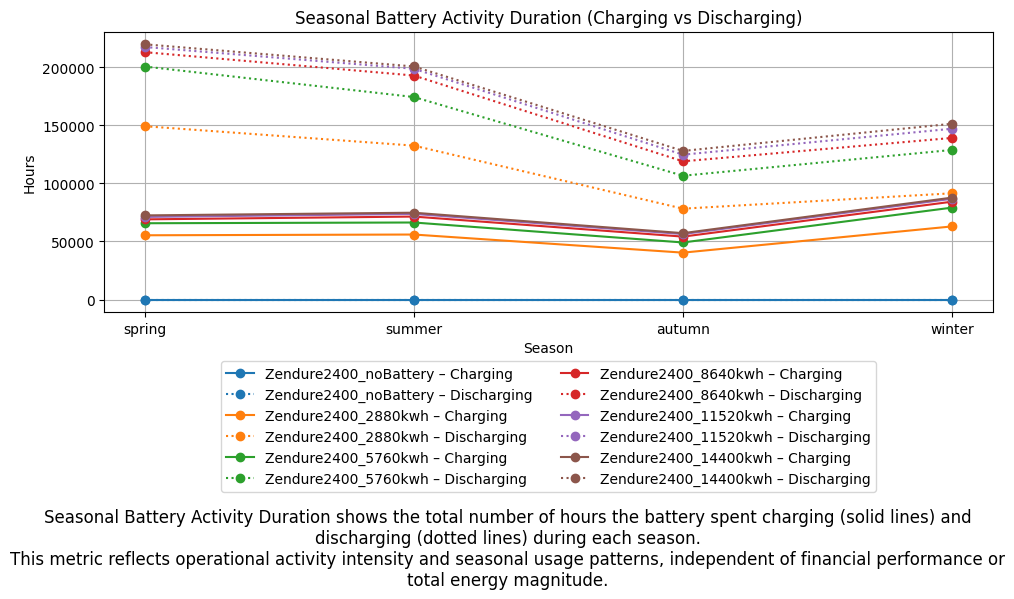

In [17]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_season_activity[df_season_activity["scenario"] == scenario]
        .sort_values("season")
    )

    color = color_cycle[i % len(color_cycle)]

    # Charging – solid
    plt.plot(
        subset["season"],
        subset["charging_hours"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Charging"
    )

    # Discharging – dotted
    plt.plot(
        subset["season"],
        subset["discharging_hours"],
        marker="o",
        linestyle=":",
        color=color,
        label=f"{scenario} – Discharging"
    )

plt.title("Seasonal Battery Activity Duration (Charging vs Discharging)")
plt.xlabel("Season")
plt.ylabel("Hours")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.grid(True)

plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Activity Duration shows the total number of hours the battery "
    "spent charging (solid lines) and discharging (dotted lines) during each season.\n"
    "This metric reflects operational activity intensity and seasonal usage patterns, "
    "independent of financial performance or total energy magnitude.",
    ha="center",
    fontsize=12,
    wrap=True
)

export_current_figure(SEASON_FIG_DIR)
plt.show()
